# **Image Classification Using the Vision Transformer Model**

In this notebook, the [Vision Transformer (ViT) Large](https://huggingface.co/google/vit-large-patch16-224-in21k) model is fine-tuned using the [CIFAR-10](https://www.cs.toronto.edu/%7Ekriz/cifar.html) dataset for image classification. This dataset consists of 60,000 RGB images distributed across 10 different classes, with 50,000 used for training and 10,000 for testing. The [ViT](https://huggingface.co/docs/transformers/model_doc/vit) model is a pioneer in applying transformer networks to computer vision, and its architecture is similar to that of [BERT](https://huggingface.co/docs/transformers/model_doc/bert). This model was pre-trained on [ImageNet21K](https://github.com/Alibaba-MIIL/ImageNet21K) at a resolution of 224x224 pixels. The images are divided into 16x16 pixel patches, which are encoded by an input embedding; these 16x16 patches are analogous to words in natural language processing. This method enables ViT models to deliver outstanding performance compared to leading convolutional neural networks, all while using fewer computational resources.



## **Imports**

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from transformers import AutoImageProcessor, TFAutoModelForImageClassification
from transformers import create_optimizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from google.colab import drive

## **Parameters**

In [ ]:
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
epochs = 5
batch_size = 128
buffer_size = 1024
AUTOTUNE = tf.data.AUTOTUNE
SEED = 123
model_name = "google/vit-large-patch16-224-in21k"

## **Prepare the dataset for training**

### **Load the dataset**

In [ ]:
(train_dataset, test_dataset), info = tfds.load("cifar10", split=["train", "test"], as_supervised=True, with_info=True)
info

tfds.core.DatasetInfo(
    name='cifar10',
    full_name='cifar10/3.0.2',
    description="""
    The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.
    """,
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    data_dir='/root/tensorflow_datasets/cifar10/3.0.2',
    file_format=tfrecord,
    download_size=162.17 MiB,
    dataset_size=132.40 MiB,
    features=FeaturesDict({
        'id': Text(shape=(), dtype=string),
        'image': Image(shape=(32, 32, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=50000, num_shards=1>,
    },
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Alex Krizhevsky},
        title = {Learni

In [ ]:
num_classes = info.features["label"].num_classes
class_names = info.features['label'].names

print("Number of classes:", num_classes)
print("Class names:", class_names)

Number of classes: 10
Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


### **Preprocessing and data augmentation**

To combat overfitting, it is crucial to use data augmentation techniques, especially given that the training dataset is relatively small. Data augmentation will enhance the model's generalization capability for image classification. To achieve this, TensorFlow layers such as [``RandomFlip``](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomFlip), [``RandomTranslation``](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomTranslation), [``RandomRotation``](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomRotation), and [``RandomZoom``](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomZoom) will be used. These layers should only be applied to the training dataset during preprocessing, which is controlled by setting the parameter ``training=True``.

Regarding image preprocessing, the generic image processor class from Hugging Face, [AutoImageProcessor](https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoImageProcessor), could be used, but it is not compatible with TensorFlow graphs, which would slow down training. Therefore, TensorFlow layers will be used for preprocessing, allowing the processing to be applied in parallel with training, significantly speeding up the training time. The [``Resizing``](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Resizing) layer will be used to resize the images and make them compatible with the model, the [``Rescaling``](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Rescaling) layer to normalize the images in the range of ``[-1;1]``, and the [``Permute``](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Permute) layer to rearrange the image channels into the second dimension, ensuring compatibility with the PyTorch model format. These three layers operate independently of the ``training`` parameter, so they are applied to both the training and testing datasets.

In [ ]:
image_processor = AutoImageProcessor.from_pretrained(model_name)
image_processor

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [ ]:
original_size = info.features["image"].shape
new_size = (image_processor.size["height"], image_processor.size["width"], 3)

original_size, new_size

((32, 32, 3), (224, 224, 3))

In [ ]:
def function_data_augmentation(input_shape, output_shape):
  return tf.keras.Sequential([
      tf.keras.Input(shape=input_shape),
      tf.keras.layers.Resizing(output_shape[0], output_shape[1]),
      tf.keras.layers.RandomFlip("horizontal"),
      tf.keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2),
      tf.keras.layers.RandomRotation(0.1),
      tf.keras.layers.RandomZoom(0.2),
      tf.keras.layers.Rescaling(1/127.5, offset=-1),
      tf.keras.layers.Permute((3, 1, 2))
  ], name="data_augmentation")

In [ ]:
tf.keras.backend.clear_session() #Clearing Keras memory

data_augmentation = function_data_augmentation(original_size, new_size)
data_augmentation.summary()

Model: "data_augmentation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 random_flip (RandomFlip)    (None, 224, 224, 3)       0         
                                                                 
 random_translation (Random  (None, 224, 224, 3)       0         
 Translation)                                                    
                                                                 
 random_rotation (RandomRot  (None, 224, 224, 3)       0         
 ation)                                                          
                                                                 
 random_zoom (RandomZoom)    (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3) 

In [ ]:
def prepare_dataset(dataset, training=True):
  if training:
    dataset = dataset.shuffle(buffer_size, seed=SEED)

  dataset = (
      dataset.
      batch(batch_size).
      map(lambda x, y : (data_augmentation(x, training=training), y), num_parallel_calls=AUTOTUNE).
      prefetch(AUTOTUNE)
  )

  return dataset

In [ ]:
train_dataset = prepare_dataset(train_dataset)
test_dataset = prepare_dataset(test_dataset, training=False)

In [ ]:
# Take a batch from the training dataset
for images, labels in train_dataset.take(1):
  print(images.shape, labels.shape)

images.numpy().min(), images.numpy().max()

(128, 3, 224, 224) (128,)


(-1.0, 1.0)

**Function to display and save images**

In [ ]:
def show_images(images, labels, predictions=None, num_examples=36, random=True,
                cmap=None, axis="off", save=False, path=""):

  # Denormalize the images
  images = (tf.transpose(images, perm=[0, 2, 3, 1]) + 1) / 2

  n = int(np.sqrt(num_examples))
  indices = np.arange(len(images))
  if random:
    np.random.shuffle(indices)

  fig, axes = plt.subplots(n, n, figsize=(1.25*n, 1.25*n))

  for i, ax in enumerate(axes.flat):
    ax.imshow(images[indices[i]], cmap=cmap)

    if predictions is not None:
      color = "#00008B" if labels[indices[i]] == predictions[indices[i]] else "red"

      ax.text(
          x=0.5, y=1.11, s=f"Label: {class_names[labels[indices[i]]]}", color=color, fontsize=6.75,
          fontweight="bold", ha="center", va="bottom", transform=ax.transAxes
      )
      ax.text(
          x=0.5, y=1, s=f"Pred: {class_names[predictions[indices[i]]]}", color=color, fontsize=6.75,
          fontweight="bold", ha="center", va="bottom", transform=ax.transAxes
      )

    else:
      ax.text(
          x=0.5, y=1, s=f"Label: {class_names[labels[indices[i]]]}", fontsize=7,
          fontweight="bold", ha="center", va="bottom", transform=ax.transAxes
      )

    ax.axis(axis)

  # Save images
  if save:
    plt.savefig(path)

  plt.tight_layout()
  plt.show()

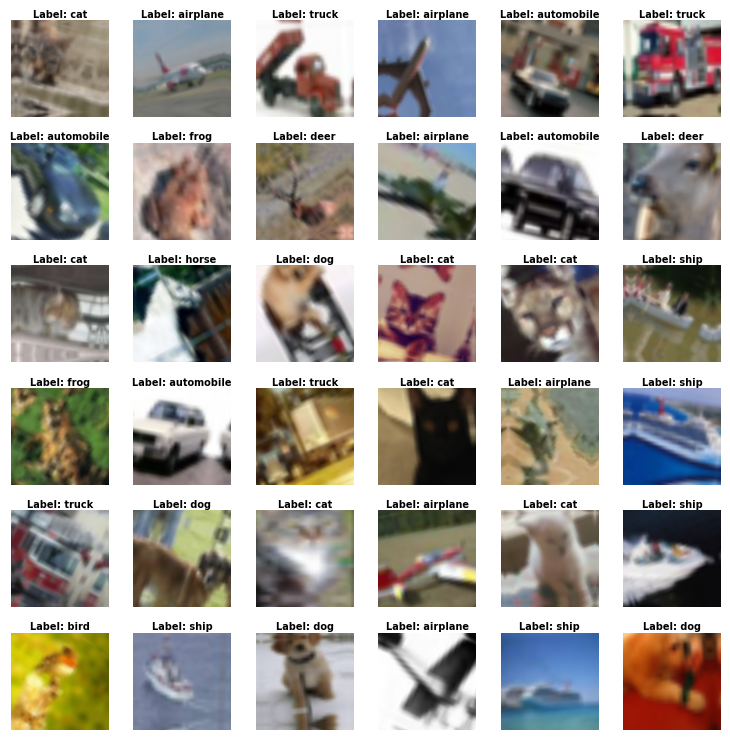

In [ ]:
# Some images from the training dataset after data augmentation
show_images(images, labels, random=False)

## **Model building and training**

To speed up the training time, Google's Colab TPU is used due to the large size of the model, which has over 300 million parameters. The model is loaded using the generic class [TFAutoModelForImageClassification](https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoModelForImageClassification), which allows for the loading of a ViT model available on Hugging Face by specifying only its name.

In [ ]:
# TPU setup

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu="local")
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.TPUStrategy(tpu)
  print("TPU initialized:")
  print("All devices: ", tf.config.list_logical_devices("TPU"))
except (ValueError, tf.errors.InvalidArgumentError, tf.errors.NotFoundError) as error:
  print(f"Error: {error}")

TPU initialized:
All devices:  [LogicalDevice(name='/device:TPU:0', device_type='TPU'), LogicalDevice(name='/device:TPU:1', device_type='TPU'), LogicalDevice(name='/device:TPU:2', device_type='TPU'), LogicalDevice(name='/device:TPU:3', device_type='TPU'), LogicalDevice(name='/device:TPU:4', device_type='TPU'), LogicalDevice(name='/device:TPU:5', device_type='TPU'), LogicalDevice(name='/device:TPU:6', device_type='TPU'), LogicalDevice(name='/device:TPU:7', device_type='TPU')]


In [ ]:
tf.keras.backend.clear_session()

with strategy.scope():
  model = TFAutoModelForImageClassification.from_pretrained(model_name, num_labels=num_classes)

  optimizer, lr_schedule = create_optimizer(
      init_lr=3e-5,
      num_train_steps=len(train_dataset)*epochs,
      weight_decay_rate=0.01,
      num_warmup_steps=0
  )
  model.compile(
      optimizer=optimizer,
      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy")],
      steps_per_execution=50
  )

model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing TFViTForImageClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTForImageClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFViTForImageClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_vi_t_for_image_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit (TFViTMainLayer)        multiple                  303301632 
                                                                 
 classifier (Dense)          multiple                  10250     
                                                                 
Total params: 303311882 (1.13 GB)
Trainable params: 303311882 (1.13 GB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Callback to stop training early if validation accuracy does not improve for 1 epoch
patience = 1
callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=patience,
    restore_best_weights=True
)

In [ ]:
# Train the model
history = model.fit(train_dataset, epochs=epochs, validation_data=test_dataset, callbacks=[callback])

Epoch 1/5
391/391 [==============================] - 591s 2s/step - loss: 0.2256 - accuracy: 0.9446 - val_loss: 0.0558 - val_accuracy: 0.9864
Epoch 2/5
391/391 [==============================] - 187s 478ms/step - loss: 0.0716 - accuracy: 0.9789 - val_loss: 0.0413 - val_accuracy: 0.9894
Epoch 3/5
391/391 [==============================] - 186s 477ms/step - loss: 0.0466 - accuracy: 0.9863 - val_loss: 0.0377 - val_accuracy: 0.9902
Epoch 4/5
391/391 [==============================] - 200s 512ms/step - loss: 0.0321 - accuracy: 0.9903 - val_loss: 0.0389 - val_accuracy: 0.9895


**Save the model**

In [ ]:
trained_model_path = "/content/drive/MyDrive/models/ImageClassification_ViT_CIFAR-10"
model.save_pretrained(trained_model_path)

## **Model Evaluation**

In [ ]:
print(model.evaluate(train_dataset, verbose=0))
print(model.evaluate(test_dataset, verbose=0))

[0.033195964992046356, 0.9900599718093872]
[0.03768973797559738, 0.9901999831199646]


### **Graphs of the metrics**

In [ ]:
# Library needed to convert Plotly interactive graphics into images
!pip install kaleido -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 13.0 MB/s eta 0:00:00


In [ ]:
# Function to plot the metrics
def plot_metrics(history=history.history, metric="loss", renderer=None, with_patience=True):
  epochs = len(history["loss"])
  losses = history[metric]
  val_losses = history[f"val_{metric}"]
  list_epochs = np.arange(1, epochs+1)
  metric = " ".join([w.capitalize() for w in metric.split("_")])

  fig=go.Figure()
  fig.add_trace(go.Scatter(x=list_epochs, y=losses, name=metric, line=dict(color="blue", width=2)))
  fig.add_trace(go.Scatter(x=list_epochs, y=val_losses, name=f"Val {metric}", line=dict(color="#FF6600", width=2)))

  last_epoch = epochs-patience if with_patience else epochs
  fig.add_vline(
      x=last_epoch, line=dict(color="red", width=2, dash="dash"),
      annotation_text="End of Training", annotation_position="top left",
      annotation=dict(font_size=12, font_color="red")
  )

  fig.update_xaxes(title_text="Epoch")
  fig.update_yaxes(title_text=metric)
  fig.update_layout(title=f"Evolution of {metric} across Epochs",
                    title_font=dict(size=20),
                    title_x=0.5,
                    height=500,
                    width=1200)

  fig.show(renderer)

In [ ]:
# Interactive graphic
plot_metrics(metric="accuracy")
plot_metrics()

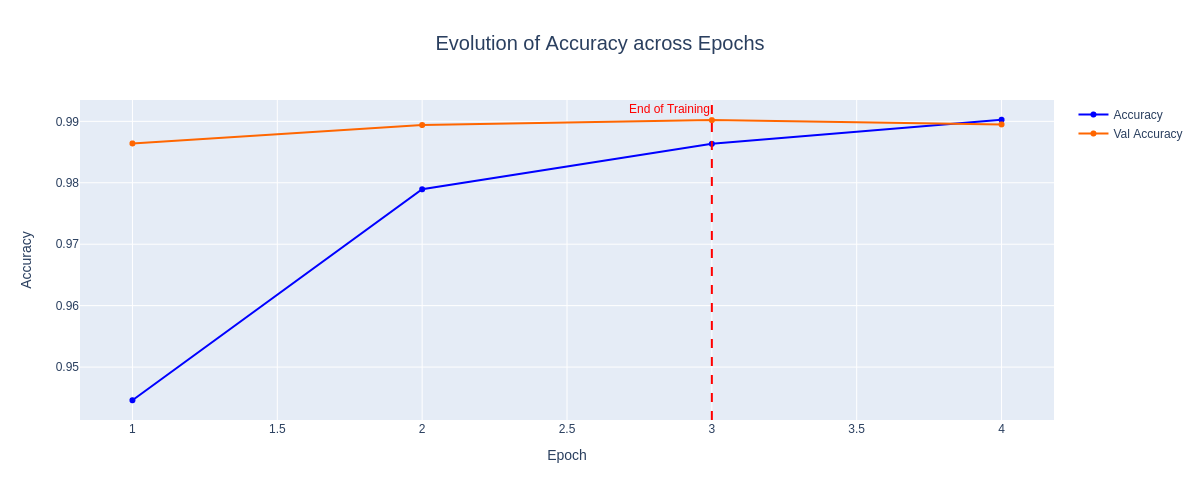

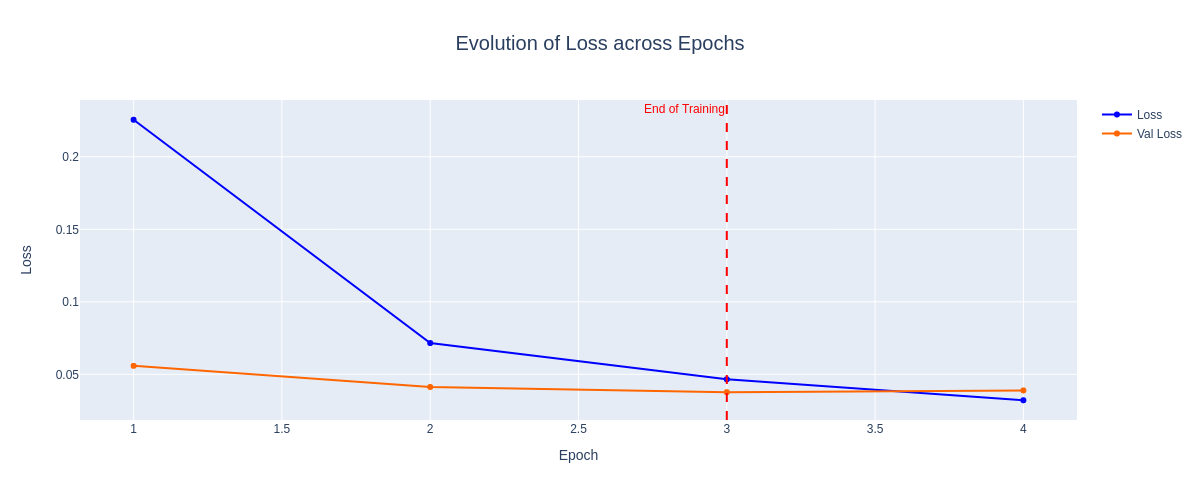

In [ ]:
# Static image for GitHub
plot_metrics(metric="accuracy", renderer="png")
plot_metrics(renderer="png")

### **Confusion Matrix**

In [ ]:
# Extract labels from the test dataset
labels_test = test_dataset.unbatch().map(lambda image, label: label)
labels_test = np.array(list(labels_test.as_numpy_iterator()))

# Generate predictions with the trained model
labels_test_pred = model.predict(test_dataset, verbose=0).logits
labels_test_pred = np.argmax(labels_test_pred, axis=-1)

# Consolidating the accuracy of the test dataset
print("Accuracy:", np.mean(labels_test == labels_test_pred))
print(f"F1 Score: {f1_score(labels_test, labels_test_pred, average='macro')}")

Accuracy: 0.9902
F1 Score: 0.9902035137635163


Frequency per Label: [1000 1000 1000 1000 1000 1000 1000 1000 1000 1000] 



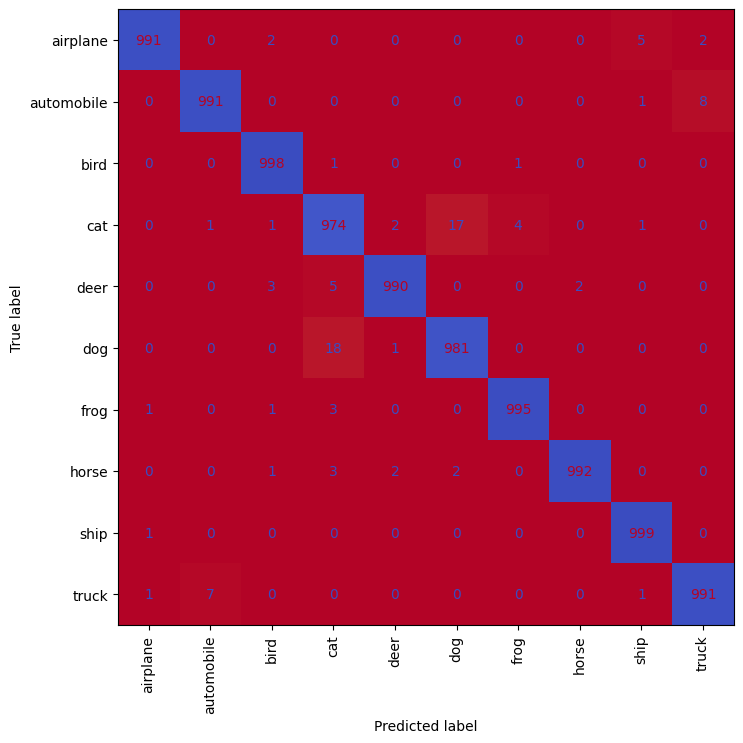

In [ ]:
print("Frequency per Label:", np.unique(labels_test, return_counts=True)[1], "\n")

cm = confusion_matrix(labels_test, labels_test_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8, 8))
cmd.plot(ax=ax, colorbar=False, cmap="coolwarm_r", xticks_rotation="vertical");

The test dataset is balanced, with 1,000 images per label. The confusion matrix shows that the model distinguishes the classes quite well, as most of the elements outside the main diagonal of the matrix are zero. However, the model has a slight difficulty differentiating between the ``cat`` and ``dog`` classes, which are the most challenging. On the other hand, it nearly classified all 1,000 images of the ``ship`` class correctly, making only one error.

## **Predictions on the test dataset**

In [ ]:
# Extract images from the test dataset
images_test = test_dataset.unbatch().map(lambda image, label: image)
images_test = np.array(list(images_test.as_numpy_iterator()))

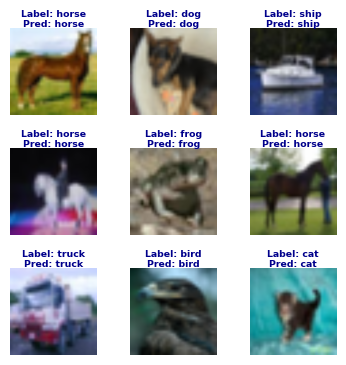

In [ ]:
show_images(images_test, labels_test, labels_test_pred, num_examples=9)

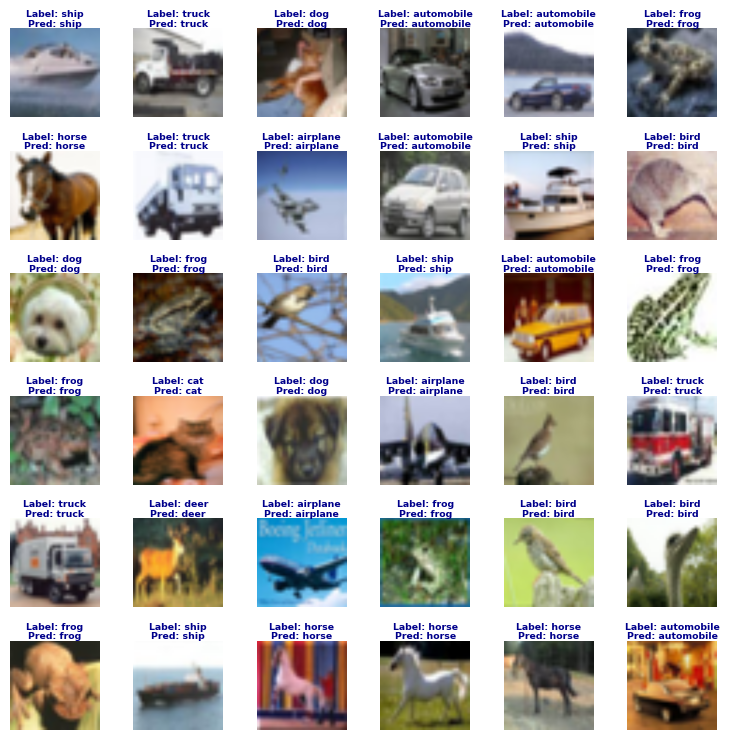

In [ ]:
show_images(images_test, labels_test, labels_test_pred, save=True, path="ImageClassification_ViT_CIFAR-10.png")

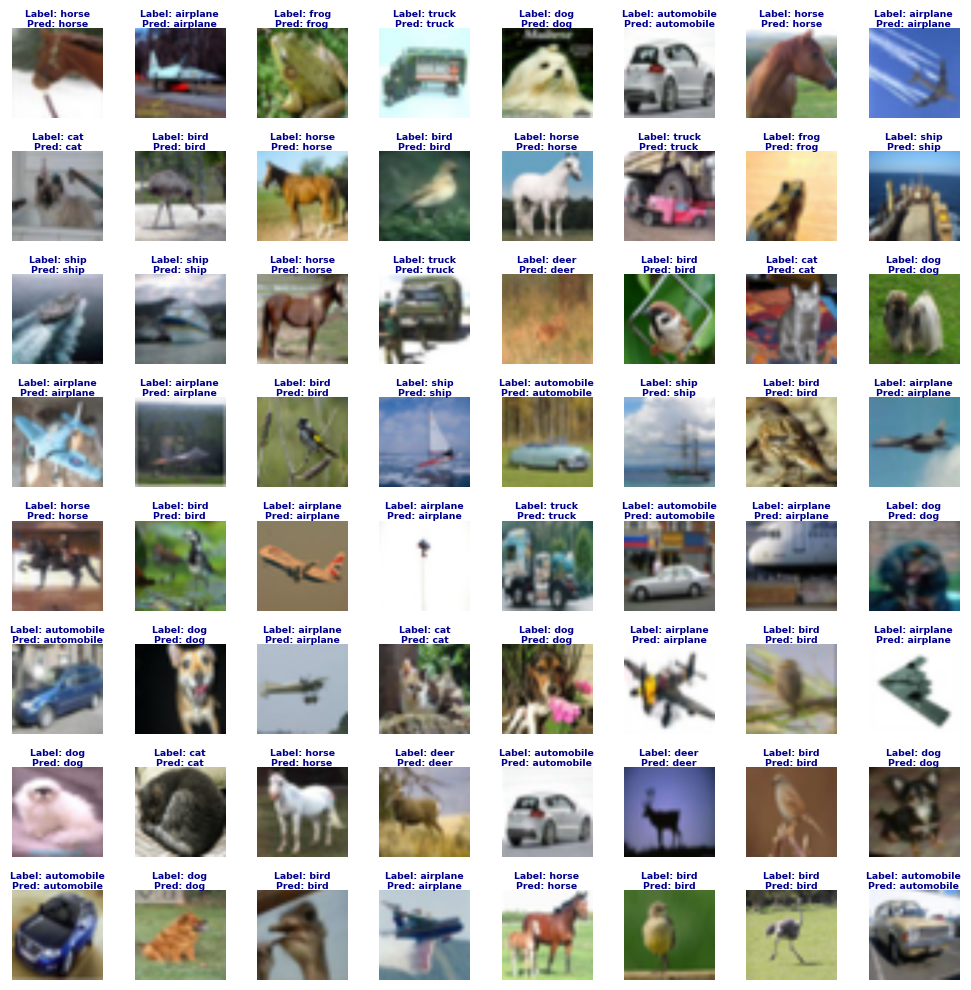

In [ ]:
show_images(images_test, labels_test, labels_test_pred, num_examples=64, random=False)

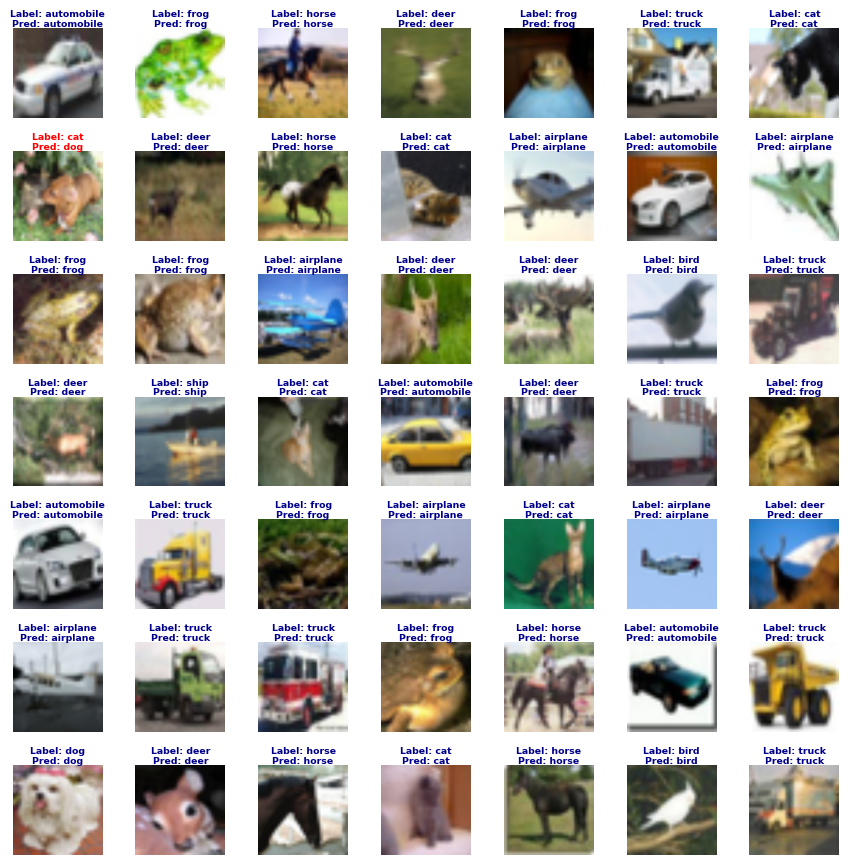

In [ ]:
# This image shows an incorrect prediction
show_images(images_test, labels_test, labels_test_pred, num_examples=49)

**Conclusion:** The model achieved an accuracy of **99.01%** on the training dataset and an accuracy and F1 score of **99.02%** on the test dataset after only 3 epochs. These results suggest that the model is highly effective for classifying images from the CIFAR-10 dataset, maintaining a good balance between precision and recall. Additionally, the absence of overfitting indicates that the data augmentation and early stopping callback were effective. If training had continued for more epochs, the training accuracy would likely have reached 100%, while the test accuracy might have started to decrease or plateau. Achieving an accuracy of 99% or higher on the CIFAR-10 test dataset is a benchmark typically reached by top computer vision models, demonstrating the impressive capability of ViT models.